In [1]:
import sys
sys.path.append('../custom_library')

In [3]:
import pandas as pd
import numpy as np
import csv
import re
import connect_to_db as cn

In [4]:
with open(f'../keywords_analysis/csv/keys/hub_comment_keys.csv', newline='') as f:
    reader = csv.reader(f)
    hub_comment_keys = list(reader)
    
with open(f'../keywords_analysis/csv/keys/normal_comment_keys.csv', newline='') as f:
    reader = csv.reader(f)
    normal_comment_keys = list(reader)
    
hub_comment_keys = list(set(sum(hub_comment_keys, [])))
normal_comment_keys = list(set(sum(normal_comment_keys, [])))

In [33]:
def get_thread_len(key, thread_len):
    thread_len = 0
    sql = f"select comment_key from comments where parent_key = '{key}';"
    result_df = cn.select_query_result_to_df(sql)
    if result_df.empty:
        return thread_len
    keys = list(np.array(result_df['comment_key'].astype(str).values.tolist()))
    thread_len += len(keys)
    
    for key in keys:
        thread_len += get_thread_len(key, thread_len)
    
    return thread_len

In [49]:
def thread_len_main(keys):
    thread_len_list = []

    for key in keys:
        thread_len = 1
        # print(key)
        sql = f"select comment_key from comments where parent_key = '{key}';"
        result_df = cn.select_query_result_to_df(sql)
        if result_df.empty:
            thread_len_list.append(thread_len)
            continue
        keys = list(np.array(result_df['comment_key'].astype(str).values.tolist()))
        thread_len += len(keys)
        # print(keys)
    
        for key in keys:
            thread_len += get_thread_len(key, thread_len)
    
        thread_len_list.append(thread_len)
    
    return thread_len_list

In [74]:
hub_len_list = thread_len_main(hub_comment_keys)
print(sum(hub_len_list) / len(hub_len_list))
normal_len_list = thread_len_main(normal_comment_keys)
print(sum(normal_len_list) / len(normal_len_list))

3.460693313127486
3.4167175935356826


In [71]:
print(sum(hub_len_list) / len(hub_len_list))
print(sum(normal_len_list) / len(normal_len_list))

3.47
3.3365


In [63]:
import pymysql.cursors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import connect_to_db as cn
from matplotlib.ticker import MaxNLocator

In [64]:
# Font 설정.
plt.rcParams.update({'font.family':'Arial'})

In [65]:
def normalization(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [66]:
def draw_multiple_cdf_normalize_y(np_result_list, title, colors, xlabel, legends, linestyles, log_scale, only_integer=False):
    if log_scale:
        title = title + '_log_scale'
    filename = title + '.eps'
    
    fig = plt.figure(figsize=(15,10))
    fig.set_facecolor('white')
    ax = fig.add_subplot()
    
    for np_result, color, legend, linestyle in zip(np_result_list, colors, legends, linestyles):
        sorted_data = np.sort(np_result)
        if legend == 'no legend':
            plt.step(sorted_data, normalization(np.arange(sorted_data.size)), color=color, linestyle=linestyle, linewidth=7)
        else:
            plt.step(sorted_data, normalization(np.arange(sorted_data.size)), label=legend, color=color, linestyle=linestyle, linewidth=7)
        if log_scale:
            plt.xscale('symlog')
            
        ax.spines['right'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        
        if only_integer:
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  
    if legend != 'no legend':
        plt.legend(prop={'size': 48 }, loc = 'lower right', framealpha=1, edgecolor='0')

    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    
    plt.savefig(f"../figure/eps/{filename}", bbox_inches='tight', format='eps')
    plt.show()

In [67]:
colors = ['#ef8a62', '#67a9cf']
linestyles = ['-', '--']

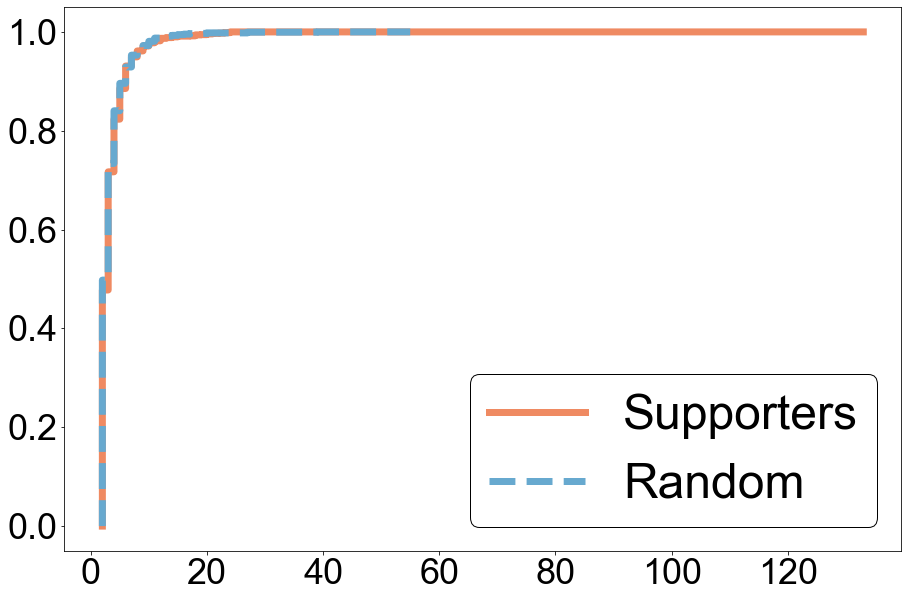

In [72]:
np_result_list = []
np_result_list.append(hub_len_list)
np_result_list.append(normal_len_list)
legends = ['Supporters', 'Random']

draw_multiple_cdf_normalize_y(np_result_list, 'cdf_nested_comments_by_words', colors, 'Number of Nested Comments', legends, linestyles, False)

In [75]:
sql = f"select distinct(author) from comments where is_valid_author=0;"
sql2 = f"select distinct(author) from posts where is_valid_author=0;"

result_df1 = cn.select_query_result_to_df(sql)
author1 = set(list(np.array(result_df1['author'].astype(str).values.tolist())))

result_df2 = cn.select_query_result_to_df(sql2)
author2 = set(list(np.array(result_df2['author'].astype(str).values.tolist())))

In [76]:
print(len(author1.union(author2)))

619


In [ ]:
sql = f"select sum(indegree) from nodes;"
sql2 = f"select sum(outdegree) from nodes;"

result_df1 = cn.select_query_result_to_df(sql)


result_df2 = cn.select_query_result_to_df(sql2)
author2 = set(list(np.array(result_df2['author'].astype(str).values.tolist())))